In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')
from typing import List

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.transforms import MelSpectrogram
from torchaudio.models import WaveRNN
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [4]:
import matplotlib
# matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5

In [5]:
import numpy as np
import IPython.display as ipd
from tqdm import tqdm
import pandas as pd
import librosa
import librosa.display

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [9]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

In [10]:
def plot_waveform_n_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 2, figsize=(10, 2))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c][0].plot(time_axis, waveform[c], linewidth=1)
        axes[c][0].set_ylim([-1.0, 1.0])
        axes[c][1].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c][0].set_ylabel(f"Channel {c+1}")
            axes[c][1].set_ylabel(f"Channel {c+1}")
        axes[c][0].set_title('Waveform')
        axes[c][1].set_title('Spectrogram')

In [43]:
save_flag = False
n_channels = 10

# Speech Commands Dataset

In [11]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, data_root, subset: str = None):
        super().__init__(data_root, download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [13]:
# Create training and testing split of the data. We do not use validation in this tutorial.
fg_train_set = SubsetSC('/data/home/geshi/data/', "training")
fg_val_set = SubsetSC('/data/home/geshi/data/', "validation")
fg_test_set = SubsetSC('/data/home/geshi/data/', "testing")

waveform, sample_rate, label, speaker_id, utterance_number = fg_train_set[0]

In [27]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("dataset size train {}, val {}, test {}".format(len(fg_train_set), len(fg_val_set), len(fg_test_set)))

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000
dataset size train 84843, val 9981, test 11005


In [42]:
labels = sorted(list(set(datapoint[2] for datapoint in fg_train_set)))
print("number of classes", len(labels))

number of classes 35


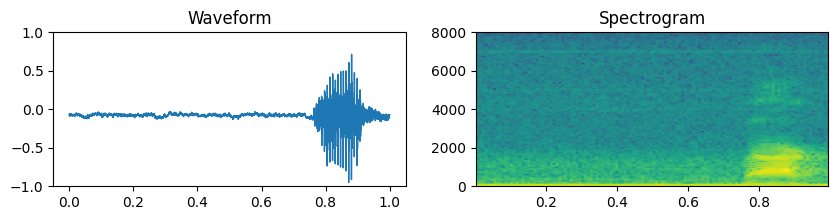

In [20]:
plot_waveform_n_specgram(waveform, sample_rate)
if save_flag:
    plt.savefig('../command.png',dpi=300)

In [24]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

# Noisy Background

In [18]:
noise_channel = torch.clamp(torch.randn_like(waveform)*0.25, min=-1, max=1)

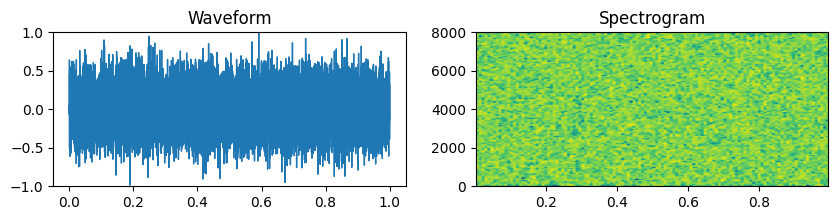

In [22]:
plot_waveform_n_specgram(noise_channel, sample_rate)
if save_flag:
    plt.savefig('../audio_noise.png',dpi=300)

In [23]:
ipd.Audio(noise_channel.numpy(), rate=sample_rate)

# Rain Forest Species Audio Dataset

In [29]:
df = pd.read_csv('/data/home/geshi/data/rfcx-species-audio-detection/train_tp.csv')

In [30]:
df.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [32]:
sample_num=3 #pick a file to display
filename=df.recording_id[sample_num]+str('.flac') #get the filename
#define the beginning time of the signal
tstart = df.t_min[sample_num] 
tend = df.t_max[sample_num] #define the end time of the signal
y,sr=librosa.load('/data/home/geshi/data/rfcx-species-audio-detection/train/'+str(filename))
# librosa.display.waveplot(y,sr=sr, x_axis='time', color='purple',offset=0.0)

In [33]:
y = torch.tensor(y)
y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=sample_rate)

In [36]:
pos = random.randint(0, len(y)//sample_rate)

In [39]:
bg_waveform = torch.clamp(y[pos*sample_rate:(pos+1)*sample_rate]*50, min=-1, max=1)

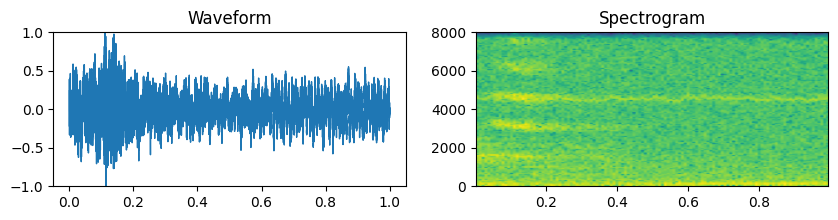

In [40]:
plot_waveform_n_specgram(bg_waveform.unsqueeze(0), sample_rate)
if save_flag:
    plt.savefig('../forest.png',dpi=300)

In [41]:
ipd.Audio(bg_waveform.numpy(), rate=sample_rate)

# Generate Synthetic Audio Data

In [21]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [84]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 64

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# Define Network

In [163]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = torch.squeeze(x)
        x = self.fc1(x)
        return x

In [99]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [164]:
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)


In [165]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the 
criterion = nn.CrossEntropyLoss()

In [166]:
def train(model, hidden, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [167]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, hidden, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [168]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, hidden, epoch, log_interval)
        test(model, hidden, epoch)
        scheduler.step()

  1%|▏                         | 0.01001335113484646/2 [00:00<00:40, 20.21s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.786351


  1%|▎                         | 0.02269692923898532/2 [00:00<00:35, 17.80s/it]

Train Epoch: 1 [1280/84843 (2%)]	Loss: 3.297558


  2%|▍                         | 0.03538050734312419/2 [00:00<00:33, 17.02s/it]

Train Epoch: 1 [2560/84843 (3%)]	Loss: 2.987040


  2%|▋                         | 0.04873164218958616/2 [00:00<00:32, 16.74s/it]

Train Epoch: 1 [3840/84843 (5%)]	Loss: 2.671362


  3%|▊                         | 0.06141522029372503/2 [00:01<00:32, 16.75s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 2.441539


  4%|▉                         | 0.07343124165554069/2 [00:01<00:32, 16.82s/it]

Train Epoch: 1 [6400/84843 (8%)]	Loss: 2.640038


  5%|█▏                        | 0.09212283044058725/2 [00:01<00:31, 16.58s/it]

Train Epoch: 1 [7680/84843 (9%)]	Loss: 2.434180


  5%|█▎                        | 0.10547396528704908/2 [00:01<00:31, 16.69s/it]

Train Epoch: 1 [8960/84843 (11%)]	Loss: 1.989031


  6%|█▌                        | 0.11748998664886473/2 [00:02<00:31, 16.77s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 1.970862


  6%|█▋                        | 0.12950600801068046/2 [00:02<00:31, 16.80s/it]

Train Epoch: 1 [11520/84843 (14%)]	Loss: 2.605381


  7%|█▊                        | 0.14152202937249636/2 [00:02<00:31, 16.84s/it]

Train Epoch: 1 [12800/84843 (15%)]	Loss: 1.643381


  8%|█▉                        | 0.15353805073431226/2 [00:02<00:30, 16.78s/it]

Train Epoch: 1 [14080/84843 (17%)]	Loss: 1.927937


  9%|██▏                       | 0.17289719626168232/2 [00:02<00:30, 16.62s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 1.825695


  9%|██▍                       | 0.18624833110814443/2 [00:03<00:29, 16.46s/it]

Train Epoch: 1 [16640/84843 (20%)]	Loss: 1.622943


 10%|██▌                       | 0.19959946595460654/2 [00:03<00:29, 16.61s/it]

Train Epoch: 1 [17920/84843 (21%)]	Loss: 1.683066


 11%|██▊                       | 0.21295060080106865/2 [00:03<00:29, 16.59s/it]

Train Epoch: 1 [19200/84843 (23%)]	Loss: 1.503287


 11%|██▉                       | 0.22630173564753076/2 [00:03<00:29, 16.57s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 1.338480


 12%|███                       | 0.23965287049399286/2 [00:04<00:29, 16.74s/it]

Train Epoch: 1 [21760/84843 (26%)]	Loss: 1.667961


 13%|███▎                      | 0.25233644859813187/2 [00:04<00:29, 16.79s/it]

Train Epoch: 1 [23040/84843 (27%)]	Loss: 1.548614


 13%|███▍                      | 0.26435246995994777/2 [00:04<00:29, 16.96s/it]

Train Epoch: 1 [24320/84843 (29%)]	Loss: 1.229667


 14%|███▌                      | 0.27636849132176367/2 [00:04<00:29, 17.03s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.229873


 14%|███▋                      | 0.28838451268357956/2 [00:04<00:29, 17.08s/it]

Train Epoch: 1 [26880/84843 (32%)]	Loss: 1.557151


 15%|███▉                      | 0.30040053404539546/2 [00:05<00:29, 17.08s/it]

Train Epoch: 1 [28160/84843 (33%)]	Loss: 1.080339


 16%|████▎                      | 0.3184245660881193/2 [00:05<00:28, 17.09s/it]

Train Epoch: 1 [29440/84843 (35%)]	Loss: 1.581809


 17%|████▍                      | 0.3304405874499352/2 [00:05<00:28, 16.97s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.452326


 17%|████▌                      | 0.3424566088117511/2 [00:05<00:28, 16.93s/it]

Train Epoch: 1 [32000/84843 (38%)]	Loss: 1.230664


 18%|████▉                       | 0.354472630173567/2 [00:05<00:27, 16.90s/it]

Train Epoch: 1 [33280/84843 (39%)]	Loss: 1.455933


 19%|████▊                     | 0.37249666221629085/2 [00:06<00:27, 16.93s/it]

Train Epoch: 1 [34560/84843 (41%)]	Loss: 1.168091


 19%|████▉                     | 0.38451268357810675/2 [00:06<00:27, 17.03s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.082897


 20%|█████▏                    | 0.39652870493992265/2 [00:06<00:27, 17.07s/it]

Train Epoch: 1 [37120/84843 (44%)]	Loss: 1.408996


 20%|█████▎                    | 0.40854472630173855/2 [00:06<00:27, 17.07s/it]

Train Epoch: 1 [38400/84843 (45%)]	Loss: 1.298032


 21%|█████▍                    | 0.42056074766355445/2 [00:07<00:26, 16.96s/it]

Train Epoch: 1 [39680/84843 (47%)]	Loss: 1.405627


 22%|█████▉                     | 0.4385847797062783/2 [00:07<00:26, 16.88s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.326265


 23%|██████                     | 0.4506008010680942/2 [00:07<00:26, 16.96s/it]

Train Epoch: 1 [42240/84843 (50%)]	Loss: 0.844344


 23%|██████▏                    | 0.4626168224299101/2 [00:07<00:26, 17.03s/it]

Train Epoch: 1 [43520/84843 (51%)]	Loss: 1.183688


 24%|██████▋                     | 0.474632843791726/2 [00:08<00:25, 17.03s/it]

Train Epoch: 1 [44800/84843 (53%)]	Loss: 0.899167


 25%|██████▍                   | 0.49265687583444984/2 [00:08<00:25, 17.02s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.074543


 25%|██████▊                    | 0.5053404539385888/2 [00:08<00:24, 16.69s/it]

Train Epoch: 1 [47360/84843 (56%)]	Loss: 0.987415


 26%|██████▉                    | 0.5180240320427278/2 [00:08<00:24, 16.60s/it]

Train Epoch: 1 [48640/84843 (57%)]	Loss: 0.987145


 27%|███████▏                   | 0.5307076101468668/2 [00:08<00:24, 16.92s/it]

Train Epoch: 1 [49920/84843 (59%)]	Loss: 1.313748


 27%|███████▎                   | 0.5427236315086827/2 [00:09<00:24, 16.97s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.764610


 28%|███████▍                   | 0.5547396528704986/2 [00:09<00:24, 16.94s/it]

Train Epoch: 1 [52480/84843 (62%)]	Loss: 1.096843


 29%|███████▋                   | 0.5727636849132225/2 [00:09<00:24, 16.98s/it]

Train Epoch: 1 [53760/84843 (63%)]	Loss: 1.161949


 29%|███████▉                   | 0.5847797062750384/2 [00:09<00:24, 17.04s/it]

Train Epoch: 1 [55040/84843 (65%)]	Loss: 0.965150


 30%|████████                   | 0.5967957276368543/2 [00:10<00:23, 17.09s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.405789


 30%|████████▏                  | 0.6088117489986702/2 [00:10<00:23, 16.88s/it]

Train Epoch: 1 [57600/84843 (68%)]	Loss: 0.927619


 31%|████████▍                  | 0.6208277703604861/2 [00:10<00:23, 17.05s/it]

Train Epoch: 1 [58880/84843 (69%)]	Loss: 0.737542


 32%|████████▌                  | 0.6388518024032099/2 [00:10<00:23, 17.03s/it]

Train Epoch: 1 [60160/84843 (71%)]	Loss: 0.886921


 33%|████████▊                  | 0.6508678237650258/2 [00:11<00:22, 17.02s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.816459


 33%|████████▉                  | 0.6635514018691648/2 [00:11<00:22, 16.74s/it]

Train Epoch: 1 [62720/84843 (74%)]	Loss: 1.199589


 34%|█████████▏                 | 0.6762349799733038/2 [00:11<00:21, 16.57s/it]

Train Epoch: 1 [64000/84843 (75%)]	Loss: 1.227332


 34%|█████████▋                  | 0.689586114819766/2 [00:11<00:21, 16.54s/it]

Train Epoch: 1 [65280/84843 (77%)]	Loss: 0.935244


 35%|█████████▍                 | 0.7029372496662281/2 [00:11<00:21, 16.53s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.986157


 36%|█████████▋                 | 0.7162883845126902/2 [00:12<00:21, 16.52s/it]

Train Epoch: 1 [67840/84843 (80%)]	Loss: 1.097524


 36%|█████████▊                 | 0.7296395193591523/2 [00:12<00:21, 16.57s/it]

Train Epoch: 1 [69120/84843 (81%)]	Loss: 0.861653


 37%|██████████                 | 0.7429906542056144/2 [00:12<00:20, 16.54s/it]

Train Epoch: 1 [70400/84843 (83%)]	Loss: 1.064952


 38%|██████████▏                | 0.7563417890520765/2 [00:12<00:20, 16.56s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.590942


 38%|██████████▍                | 0.7696929238985386/2 [00:12<00:20, 16.58s/it]

Train Epoch: 1 [72960/84843 (86%)]	Loss: 0.826773


 39%|██████████▌                | 0.7830440587450007/2 [00:13<00:20, 16.56s/it]

Train Epoch: 1 [74240/84843 (87%)]	Loss: 0.979698


 40%|██████████▋                | 0.7957276368491397/2 [00:13<00:20, 16.69s/it]

Train Epoch: 1 [75520/84843 (89%)]	Loss: 0.858019


 40%|██████████▉                | 0.8077436582109556/2 [00:13<00:20, 16.82s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.762212


 41%|███████████                | 0.8210947930574177/2 [00:13<00:19, 16.71s/it]

Train Epoch: 1 [78080/84843 (92%)]	Loss: 0.757738


 42%|███████████▎               | 0.8397863818424647/2 [00:14<00:19, 16.88s/it]

Train Epoch: 1 [79360/84843 (94%)]	Loss: 1.056288


 43%|███████████▍               | 0.8518024032042806/2 [00:14<00:19, 16.89s/it]

Train Epoch: 1 [80640/84843 (95%)]	Loss: 0.559512


 43%|███████████▋               | 0.8638184245660965/2 [00:14<00:19, 16.94s/it]

Train Epoch: 1 [81920/84843 (97%)]	Loss: 0.787417


 44%|███████████▊               | 0.8758344459279124/2 [00:14<00:19, 16.94s/it]

Train Epoch: 1 [83200/84843 (98%)]	Loss: 0.711501


 44%|████████████               | 0.8891855807743745/2 [00:14<00:17, 16.02s/it]

Train Epoch: 1 [84480/84843 (100%)]	Loss: 0.458449


 51%|█████████████▋             | 1.0106809078771797/2 [00:16<00:13, 13.60s/it]


Test Epoch: 1	Accuracy: 7922/11005 (72%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.710193


 51%|██████████████▎             | 1.018691588785057/2 [00:16<00:14, 14.38s/it]

Train Epoch: 2 [1280/84843 (2%)]	Loss: 0.754320


 52%|█████████████▉             | 1.0333778371161653/2 [00:16<00:14, 15.40s/it]

Train Epoch: 2 [2560/84843 (3%)]	Loss: 0.747187


 52%|██████████████▏            | 1.0467289719626274/2 [00:17<00:15, 16.07s/it]

Train Epoch: 2 [3840/84843 (5%)]	Loss: 0.635971


 53%|██████████████▎            | 1.0600801068090895/2 [00:17<00:15, 16.42s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.505933


 54%|██████████████▍            | 1.0734312416555516/2 [00:17<00:15, 16.56s/it]

Train Epoch: 2 [6400/84843 (8%)]	Loss: 0.885087


 54%|██████████████▋            | 1.0867823765020137/2 [00:17<00:15, 16.59s/it]

Train Epoch: 2 [7680/84843 (9%)]	Loss: 0.626314


 55%|██████████████▊            | 1.1001335113484758/2 [00:17<00:14, 16.61s/it]

Train Epoch: 2 [8960/84843 (11%)]	Loss: 0.772029


 56%|███████████████▌            | 1.113484646194938/2 [00:18<00:14, 16.62s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.080875


 56%|████████████████▉             | 1.1268357810414/2 [00:18<00:14, 16.70s/it]

Train Epoch: 2 [11520/84843 (14%)]	Loss: 0.848921


 57%|███████████████▍           | 1.1401869158878621/2 [00:18<00:14, 16.72s/it]

Train Epoch: 2 [12800/84843 (15%)]	Loss: 0.681786


 58%|███████████████▌           | 1.1535380507343242/2 [00:18<00:14, 16.60s/it]

Train Epoch: 2 [14080/84843 (17%)]	Loss: 0.703692


 59%|███████████████▊           | 1.1728971962616943/2 [00:19<00:13, 16.76s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.807466


 59%|████████████████           | 1.1855807743658333/2 [00:19<00:13, 16.70s/it]

Train Epoch: 2 [16640/84843 (20%)]	Loss: 0.690458


 60%|████████████████▏          | 1.1975967957276492/2 [00:19<00:13, 16.79s/it]

Train Epoch: 2 [17920/84843 (21%)]	Loss: 0.662888


 60%|████████████████▉           | 1.209612817089465/2 [00:19<00:13, 16.79s/it]

Train Epoch: 2 [19200/84843 (23%)]	Loss: 0.898532


 61%|█████████████████           | 1.221628838451281/2 [00:20<00:13, 16.83s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.036777


 62%|█████████████████▎          | 1.233644859813097/2 [00:20<00:12, 16.94s/it]

Train Epoch: 2 [21760/84843 (26%)]	Loss: 0.802179


 63%|████████████████▉          | 1.2516688918558208/2 [00:20<00:12, 16.80s/it]

Train Epoch: 2 [23040/84843 (27%)]	Loss: 0.552914


 63%|█████████████████          | 1.2636849132176367/2 [00:20<00:12, 16.75s/it]

Train Epoch: 2 [24320/84843 (29%)]	Loss: 0.709743


 64%|█████████████████▏         | 1.2757009345794526/2 [00:20<00:12, 16.80s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.647836


 64%|█████████████████▍         | 1.2877169559412684/2 [00:21<00:11, 16.80s/it]

Train Epoch: 2 [26880/84843 (32%)]	Loss: 0.576756


 65%|█████████████████▋         | 1.3057409879839923/2 [00:21<00:11, 16.86s/it]

Train Epoch: 2 [28160/84843 (33%)]	Loss: 0.612584


 66%|█████████████████▊         | 1.3177570093458082/2 [00:21<00:11, 16.84s/it]

Train Epoch: 2 [29440/84843 (35%)]	Loss: 0.825430


 66%|██████████████████▌         | 1.329773030707624/2 [00:21<00:11, 16.86s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 1.048948


 67%|███████████████████▍         | 1.34178905206944/2 [00:22<00:11, 16.83s/it]

Train Epoch: 2 [32000/84843 (38%)]	Loss: 0.852960


 68%|██████████████████▉         | 1.353805073431256/2 [00:22<00:10, 16.82s/it]

Train Epoch: 2 [33280/84843 (39%)]	Loss: 0.745249


 69%|██████████████████▌        | 1.3718291054739797/2 [00:22<00:10, 16.83s/it]

Train Epoch: 2 [34560/84843 (41%)]	Loss: 1.045457


 69%|██████████████████▋        | 1.3838451268357956/2 [00:22<00:10, 16.80s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.728753


 70%|██████████████████▊        | 1.3965287049399346/2 [00:22<00:10, 16.74s/it]

Train Epoch: 2 [37120/84843 (44%)]	Loss: 0.731571


 70%|███████████████████        | 1.4085447263017505/2 [00:23<00:09, 16.71s/it]

Train Epoch: 2 [38400/84843 (45%)]	Loss: 0.666813


 71%|███████████████████▏       | 1.4205607476635664/2 [00:23<00:09, 16.71s/it]

Train Epoch: 2 [39680/84843 (47%)]	Loss: 0.811274


 72%|███████████████████▍       | 1.4385847797062903/2 [00:23<00:09, 16.77s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.902744


 73%|███████████████████▌       | 1.4506008010681062/2 [00:23<00:09, 16.73s/it]

Train Epoch: 2 [42240/84843 (50%)]	Loss: 0.940902


 73%|████████████████████▍       | 1.462616822429922/2 [00:24<00:08, 16.73s/it]

Train Epoch: 2 [43520/84843 (51%)]	Loss: 0.989350


 74%|████████████████████▋       | 1.474632843791738/2 [00:24<00:08, 16.74s/it]

Train Epoch: 2 [44800/84843 (53%)]	Loss: 0.448782


 75%|████████████████████▏      | 1.4926568758344618/2 [00:24<00:08, 16.79s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.543365


 75%|████████████████████▎      | 1.5046728971962777/2 [00:24<00:08, 16.81s/it]

Train Epoch: 2 [47360/84843 (56%)]	Loss: 0.497307


 76%|████████████████████▍      | 1.5166889185580936/2 [00:24<00:08, 16.79s/it]

Train Epoch: 2 [48640/84843 (57%)]	Loss: 0.999316


 76%|████████████████████▋      | 1.5287049399199095/2 [00:25<00:07, 16.80s/it]

Train Epoch: 2 [49920/84843 (59%)]	Loss: 0.751978


 77%|████████████████████▊      | 1.5407209612817254/2 [00:25<00:07, 16.79s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.695589


 78%|█████████████████████      | 1.5587449933244493/2 [00:25<00:07, 16.79s/it]

Train Epoch: 2 [52480/84843 (62%)]	Loss: 0.703706


 79%|█████████████████████▏     | 1.5707610146862652/2 [00:25<00:07, 16.78s/it]

Train Epoch: 2 [53760/84843 (63%)]	Loss: 0.602787


 79%|██████████████████████▏     | 1.582777036048081/2 [00:26<00:06, 16.77s/it]

Train Epoch: 2 [55040/84843 (65%)]	Loss: 0.914467


 80%|██████████████████████▎     | 1.594793057409897/2 [00:26<00:06, 16.78s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.831984


 81%|█████████████████████▊     | 1.6128170894526208/2 [00:26<00:06, 16.76s/it]

Train Epoch: 2 [57600/84843 (68%)]	Loss: 0.814926


 81%|█████████████████████▉     | 1.6255006675567598/2 [00:26<00:06, 16.78s/it]

Train Epoch: 2 [58880/84843 (69%)]	Loss: 0.626585


 82%|██████████████████████     | 1.6375166889185757/2 [00:26<00:06, 16.80s/it]

Train Epoch: 2 [60160/84843 (71%)]	Loss: 0.686664


 82%|██████████████████████▎    | 1.6495327102803916/2 [00:27<00:05, 16.82s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.508564


 83%|██████████████████████▍    | 1.6615487316422075/2 [00:27<00:05, 16.81s/it]

Train Epoch: 2 [62720/84843 (74%)]	Loss: 0.589731


 84%|██████████████████████▋    | 1.6795727636849314/2 [00:27<00:05, 16.77s/it]

Train Epoch: 2 [64000/84843 (75%)]	Loss: 0.827817


 85%|██████████████████████▊    | 1.6915887850467473/2 [00:27<00:05, 16.81s/it]

Train Epoch: 2 [65280/84843 (77%)]	Loss: 0.731424


 85%|██████████████████████▉    | 1.7036048064085632/2 [00:28<00:05, 16.91s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.859064


 86%|████████████████████████    | 1.715620827770379/2 [00:28<00:04, 16.84s/it]

Train Epoch: 2 [67840/84843 (80%)]	Loss: 1.181657


 86%|████████████████████████▏   | 1.727636849132195/2 [00:28<00:04, 16.81s/it]

Train Epoch: 2 [69120/84843 (81%)]	Loss: 0.474081


 87%|███████████████████████▌   | 1.7456608811749188/2 [00:28<00:04, 16.74s/it]

Train Epoch: 2 [70400/84843 (83%)]	Loss: 0.837574


 88%|███████████████████████▋   | 1.7583444592790578/2 [00:29<00:04, 16.69s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.592346


 89%|███████████████████████▉   | 1.7703604806408737/2 [00:29<00:03, 16.67s/it]

Train Epoch: 2 [72960/84843 (86%)]	Loss: 0.754299


 89%|████████████████████████   | 1.7830440587450127/2 [00:29<00:03, 16.65s/it]

Train Epoch: 2 [74240/84843 (87%)]	Loss: 0.619093


 90%|████████████████████████▎  | 1.7963951935914748/2 [00:29<00:03, 16.53s/it]

Train Epoch: 2 [75520/84843 (89%)]	Loss: 0.598219


 90%|█████████████████████████▎  | 1.809746328437937/2 [00:29<00:03, 16.68s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.619968


 91%|████████████████████████▌  | 1.8217623497997528/2 [00:30<00:02, 16.75s/it]

Train Epoch: 2 [78080/84843 (92%)]	Loss: 0.905664


 92%|████████████████████████▊  | 1.8404539385847998/2 [00:30<00:02, 16.68s/it]

Train Epoch: 2 [79360/84843 (94%)]	Loss: 0.595190


 93%|█████████████████████████  | 1.8538050734312619/2 [00:30<00:02, 16.47s/it]

Train Epoch: 2 [80640/84843 (95%)]	Loss: 0.548863


 93%|██████████████████████████▏ | 1.867156208277724/2 [00:30<00:02, 16.25s/it]

Train Epoch: 2 [81920/84843 (97%)]	Loss: 0.676421


 94%|██████████████████████████▎ | 1.880507343124186/2 [00:31<00:01, 16.17s/it]

Train Epoch: 2 [83200/84843 (98%)]	Loss: 0.622878


 95%|█████████████████████████▌ | 1.8965287049399406/2 [00:31<00:01, 14.30s/it]

Train Epoch: 2 [84480/84843 (100%)]	Loss: 0.415473


100%|███████████████████████████| 2.0000000000000218/2 [00:32<00:00, 16.23s/it]


Test Epoch: 2	Accuracy: 8373/11005 (76%)



In [169]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [170]:
ig = IntegratedGradients(model)
sa = Saliency(model)
dl = DeepLift(model)
fa = FeatureAblation(model)

In [171]:
dataiter = iter(test_loader)
data, target = next(dataiter)
data = data.to(device)
target = target.to(device)

In [172]:
outputs = model(data)

In [173]:
outputs.shape

torch.Size([64, 35])

In [174]:
preds = outputs.argmax(dim=-1)

In [175]:
preds.shape

torch.Size([64])

In [176]:
sa_attr = sa.attribute(data, preds)

In [177]:
sa_attr

tensor([[[1.4683e-03, 1.0771e-03, 6.8619e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[2.4682e-02, 6.1891e-02, 2.0238e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[1.1010e-03, 1.7035e-04, 2.4217e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        ...,

        [[2.1359e-02, 8.3601e-03, 2.1963e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[2.8490e-03, 8.5594e-04, 5.0397e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]], device='cuda:0')

# Prepare

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([128, 3, 224, 224])


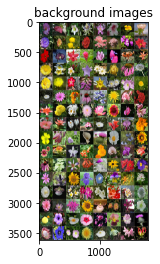

In [13]:
# Get a batch of training data
inputs, classes = next(iter(bg_trainloader))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="background images")

torch.Size([128, 3, 32, 32])


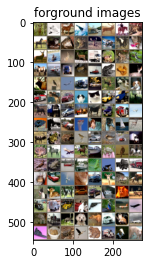

In [14]:
# Get a batch of training data
inputs, classes = next(iter(fg_trainloader))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="forground images")

In [15]:
bg_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
    ]),
}

In [16]:
bg_trainset = datasets.Flowers102('../../data', split='train', transform=bg_data_transforms['train'], download=True)
bg_trainloader = torch.utils.data.DataLoader(bg_trainset, batch_size=batch_size, shuffle=True, num_workers=0)

bg_valset = datasets.Flowers102('../../data', split='val', transform=bg_data_transforms['val'], download=True)
bg_valloader = torch.utils.data.DataLoader(bg_valset, batch_size=batch_size, shuffle=False, num_workers=0)

bg_testset = datasets.Flowers102('../../data', split='test', transform=bg_data_transforms['val'], download=True)
bg_testloader = torch.utils.data.DataLoader(bg_testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
fg_data_transforms = {
    'train': transforms.Compose([
    ]),
    'val': transforms.Compose([
    ]),
}

In [18]:
fg_trainset = datasets.CIFAR10('../../data', train=True, transform=fg_data_transforms['train'], download=True)
fg_trainloader = torch.utils.data.DataLoader(fg_trainset, batch_size=batch_size, shuffle=True, num_workers=0)

fg_valset = datasets.CIFAR10('../../data', train=False, transform=fg_data_transforms['val'], download=True)
fg_valloader = torch.utils.data.DataLoader(fg_valset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
for img, label in bg_trainset:
    print(type(img), label, img.size, img.getextrema())
    break

<class 'PIL.Image.Image'> 0 (224, 224) ((1, 210), (2, 211), (0, 227))


In [20]:
for img, label in fg_trainset:
    print(type(img), label, img.size, img.getextrema())
    break

<class 'PIL.Image.Image'> 6 (32, 32) ((0, 255), (0, 253), (0, 235))


# Random Background Fixed Position

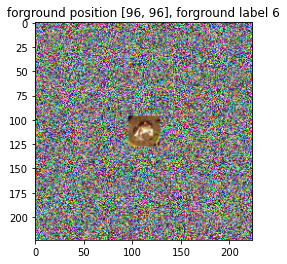

In [27]:
for img, label in fg_trainset:
    forground = np.array(img)
    fg_label = label
    background = np.random.randint(0, 256, input_size, dtype=np.uint8)
    pos = [32*3, 32*3]
    background[pos[0]:pos[0]+32, pos[1]:pos[1]+32] = forground
    fig = plt.figure()
    plt.imshow(background)
    plt.title(f'forground position {pos}, forground label {fg_label}')
    plt.show()
    plt.close(fig)
    break

# Random Background Random Position

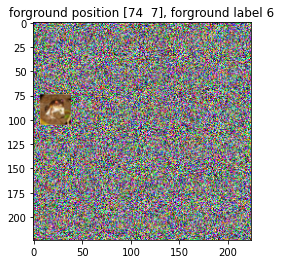

In [28]:
for img, label in fg_trainset:
    forground = np.array(img)
    fg_label = label
    background = np.random.randint(0, 256, input_size, dtype=np.uint8)
    pos = np.random.randint(0, 32*6, 2, dtype=np.uint8)
    background[pos[0]:pos[0]+32, pos[1]:pos[1]+32] = forground
    fig = plt.figure()
    plt.imshow(background)
    plt.title(f'forground position {pos}, forground label {fg_label}')
    plt.show()
    plt.close(fig)
    break

# Structural Background Fixed Position

(224, 224, 3) <class 'int'> 6 <class 'int'> 73


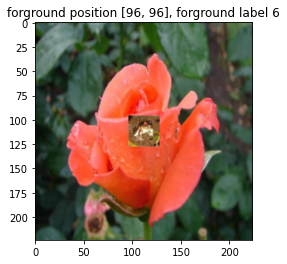

In [35]:
for img, label in fg_trainset:
    forground = np.array(img)
    fg_label = label
    bg_id = np.random.randint(0, len(bg_trainset))
    background = np.array(copy.deepcopy(bg_trainset[bg_id][0]))
    bg_label = bg_trainset[bg_id][1]
    print(background.shape, type(fg_label), fg_label, type(bg_label), bg_label)
    pos = [32*3, 32*3]
    background[pos[0]:pos[0]+32, pos[1]:pos[1]+32] = forground
    fig = plt.figure()
    plt.imshow(background)
    plt.title(f'forground position {pos}, forground label {fg_label}')
    plt.show()
    plt.close(fig)
    break

# Structural Background Random Position

(224, 224, 3) <class 'int'> 6 <class 'int'> 59


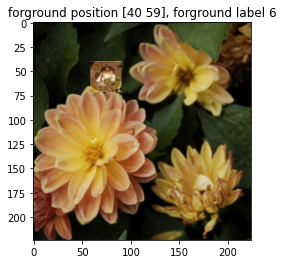

In [36]:
for img, label in fg_trainset:
    forground = np.array(img)
    fg_label = label
    bg_id = np.random.randint(0, len(bg_trainset))
    background = np.array(copy.deepcopy(bg_trainset[bg_id][0]))
    bg_label = bg_trainset[bg_id][1]
    print(background.shape, type(fg_label), fg_label, type(bg_label), bg_label)
    pos = np.random.randint(0, 32*6, 2, dtype=np.uint8)
    background[pos[0]:pos[0]+32, pos[1]:pos[1]+32] = forground
    fig = plt.figure()
    plt.imshow(background)
    plt.title(f'forground position {pos}, forground label {fg_label}')
    plt.show()
    plt.close(fig)
    break

In [46]:
idx = 5000
f'{idx:04d}'

'5000'